# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression


# Open data and prepare it

In [2]:
file_path = './data/synthetic_data_lung_cancer.csv'
df = pd.read_csv(file_path)

# Using a smaller subset for performance issues
subset_fraction = 0.3
df = df.sample(frac=subset_fraction, random_state=42)

# # Handle Missing Values
# df.isnull().sum()  # Check for missing values
# df = df.dropna()    # Drop rows with missing values

# # Identify and Remove Outliers
# Q1 = df['TIME'].quantile(0.25)
# Q3 = df['TIME'].quantile(0.75)
# IQR = Q3 - Q1

# # Define upper and lower bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Remove outliers
# df = df[(df['TIME'] >= lower_bound) & (df['TIME'] <= upper_bound)]

# Build the target feature ('DIED')
df['DIED'] = 0

# Identify rows where the "death" state is present
death_rows = df[df['DEFINITION_ID'].str.lower() == 'death']

# Iterate through each death row and update DIED column for corresponding rows
for _, death_row in death_rows.iterrows():
    patient_id = death_row['SUBJECT_ID']
    death_time = death_row['TIME']
    
    if death_time < 5:
        # Update DIED to 1 for rows with the same PATIENT_ID and TIME within 1 year
        df.loc[(df['SUBJECT_ID'] == patient_id), 'DIED'] = 1

# Delete the rows indicating death as that is what we are trying to predict
df = df[df['DEFINITION_ID'].str.lower() != 'death']

# Keep time but proceed to bining and merging with 'DEFINITION_ID' features
# Allow us to retain more information about the timeframe in which the procedure happened
df['TIME'] = np.floor(df['TIME']).astype(int)
df['DEFINITION_ID'] = df['DEFINITION_ID'] + '_' + df['TIME'].astype(str)

# Drop 'TIME' to focus on 'DEFINITION_ID'
df= df.drop(['TIME'], axis=1)

# Proceed to one-hot encode and group together all interventions happening on one patient
# One-hot encode the 'DEFINITION_ID' feature
df = pd.get_dummies(df, columns=['DEFINITION_ID'], prefix='DEF')
# Group by 'SUBJECT_ID' and perform a logical OR on 'DIED'
df = df.groupby('SUBJECT_ID').max()

# Separate features and target variable
X = df.drop(['DIED'], axis=1)
y = df['DIED']

df.head()

# Selecting features

[1.19554181e-02 1.05003133e-02 9.90664088e-03 9.29377487e-03
 8.27226276e-03 7.32014939e-03 7.26242168e-03 6.76369559e-03
 6.37035372e-03 6.30782909e-03 6.07383570e-03 5.87803579e-03
 5.64495990e-03 5.52563406e-03 5.29412216e-03 5.23697338e-03
 5.14692904e-03 5.09514178e-03 5.05246387e-03 4.98249908e-03
 4.92360274e-03 4.81274903e-03 4.78438951e-03 4.72437296e-03
 4.65699576e-03 4.59035426e-03 4.48425307e-03 4.44430075e-03
 4.42511387e-03 4.31789585e-03 4.28941735e-03 4.24416468e-03
 4.21625289e-03 4.21065204e-03 4.16030350e-03 4.13502147e-03
 4.10263631e-03 4.10065898e-03 4.06898379e-03 3.98871099e-03
 3.98306945e-03 3.94985532e-03 3.90342586e-03 3.84886418e-03
 3.84054972e-03 3.82126387e-03 3.81850783e-03 3.76785013e-03
 3.75773875e-03 3.73710086e-03 3.71174636e-03 3.69754993e-03
 3.68247410e-03 3.65535189e-03 3.62520055e-03 3.61309635e-03
 3.58998637e-03 3.57444322e-03 3.52486589e-03 3.49529935e-03
 3.47479576e-03 3.47279865e-03 3.42309542e-03 3.41262153e-03
 3.40534956e-03 3.388211

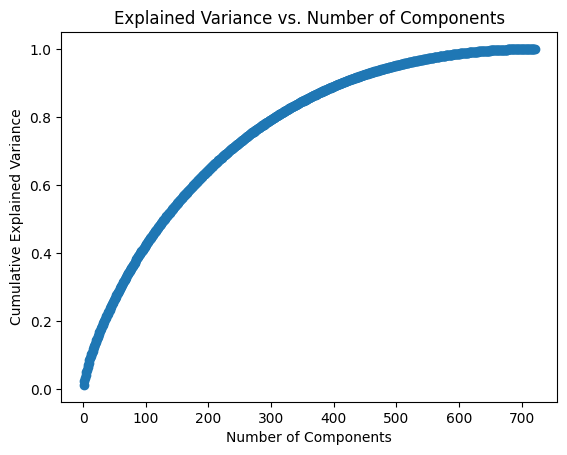

In [3]:
# PCA
# Standardize the features (important for PCA)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
num_components = min(X.shape[0], X.shape[1])
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_standardized)

# Print the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Compute and display cumulative explained variance
# Here it seem the sweet spot is between 40 and 120 features
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Select the desired number of components based on the explained variance
desired_num_components = 50  # Change this as needed
selected_components = X_pca[:, :desired_num_components]

# Create a DataFrame with the selected components and target variable
pca_selected = pd.DataFrame(selected_components, columns=[f'PC{i+1}' for i in range(desired_num_components)])
pca_selected['DIED'] = y.values

In [4]:
pca_selected.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,DIED
0,-0.336183,-6.164698,-2.262103,4.540627,-0.965901,-1.386492,2.108267,-2.403230,-2.720837,1.320499,...,2.191235,-0.105271,-3.357913,1.712786,1.027593,-0.685005,-1.491926,0.234711,-0.655066,0
1,-0.084151,-7.458343,-1.506651,7.072413,-0.945564,-0.382098,0.347414,-2.260617,-0.799293,1.656117,...,0.231884,0.158461,0.890511,0.452208,-0.789140,-0.567572,0.363368,-0.292272,-2.368077,0
2,-0.998283,-2.450408,-1.820969,5.802685,-1.563911,-3.497125,4.113166,13.366781,-2.337697,2.097743,...,-8.834208,0.876093,-0.795403,-4.353067,-0.608211,-1.880011,-6.032814,-0.477520,1.897830,0
3,-0.379897,-5.431292,-2.044383,6.555119,-1.046516,-1.292928,1.673074,5.937770,-3.960376,2.591551,...,-1.663786,-1.127538,2.732627,1.314490,0.404285,-0.547507,-1.381568,0.590509,-2.119943,0
4,0.054092,-8.176431,-2.363319,5.355403,-0.743603,-0.411066,0.557828,-2.236036,-0.312253,0.688716,...,0.252810,0.573500,0.998507,0.370817,0.193931,0.688738,-0.426988,-0.285193,-2.139506,0


In [5]:
# Separate features and target variable
X_tweaked = pca_selected.drop(['DIED'], axis=1)
y_tweaked = pca_selected['DIED']
X_train, X_test, y_train, y_test = train_test_split(X_tweaked, y_tweaked, test_size=0.2, random_state=42)

Concerning stepwise selection, it is sadly too computationally costly and we weren't able to implement it.

In [6]:
# # STEPWISE SELECTION
# # Separate features and target variable
# X = pca_selected.drop(['DIED'], axis=1)
# y = pca_selected['DIED']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the base model for evaluation
# base_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=100)

# # Stepwise selection forward
# sfs_forward = SequentialFeatureSelector(base_model, n_features_to_select=10, direction='forward', cv=5)
# sfs_forward.fit(X_train, y_train)

# # Get the selected features
# selected_features_forward = X_train.columns[sfs_forward.get_support()]

# # Train the model on the selected features
# base_model.fit(X_train[selected_features_forward], y_train)

# # Make predictions on the test set using the selected features
# y_pred_forward = base_model.predict_proba(X_test[selected_features_forward])[:, 1]

# # Evaluate AUC-ROC on the test set
# auc_forward = roc_auc_score(y_test, y_pred_forward)
# print("AUC-ROC with forward selection:", auc_forward)

# # Stepwise selection backward
# sfs_backward = SequentialFeatureSelector(base_model, n_features_to_select=5, direction='backward', cv=5)
# sfs_backward.fit(X_train, y_train)

# # Get the selected features
# selected_features_backward = X_train.columns[sfs_backward.get_support()]

# # Train the model on the selected features
# base_model.fit(X_train[selected_features_backward], y_train)

# # Make predictions on the test set using the selected features
# y_pred_backward = base_model.predict_proba(X_test[selected_features_backward])[:, 1]

# # Evaluate AUC-ROC on the test set
# auc_backward = roc_auc_score(y_test, y_pred_backward)
# print("AUC-ROC with backward selection:", auc_backward)

We couldn't dig very deep either into the graph based approach as it was very costly to go through every feature to build the graph

In [7]:
# # GRAPH BASED APPROACH (TOO COSTLY)
# # Create a directed graph
# G = nx.DiGraph()

# # Add nodes and edges based on your features
# for _, row in df.iterrows():
#     if row["SUBJECT_ID"] not in G:
#         G.add_node(row["SUBJECT_ID"])
#     if row["DEFINITION_ID"] not in G:
#         G.add_node(row["DEFINITION_ID"])
#     G.add_edge(row["SUBJECT_ID"], row["DEFINITION_ID"])

# # Visualize the graph (optional)
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, font_weight="bold", node_size=700, node_color="skyblue")
# plt.show()

# Setting up model, predicting and calculating AUROC

In [8]:
# Testing our work on features with Gradient Boosting model
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=100)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_pred_gb)
print("Gradient Boosting AUC-ROC on Test Set 1:", auc_gb)

Gradient Boosting AUC-ROC on Test Set 1: 0.8071895424836601
